## 3. OBTENCIÓN DEL MODELO PREDICTIVO (RANDOM FOREST)

Se obtiene el árbol de decisión Random Forest y se evalúa. 

In [1]:
#IMPORTAR LIBRERÍAS
import numpy as np #Numpy
import pandas as pd #Pandas 
import matplotlib.pyplot as plt #Matplotlib
import os
from sklearn import preprocessing #metodos de machine learning optimizados y validados
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier #RANDOM FOREST
from sklearn import tree #CART
from subprocess import call
from sklearn.tree import export_graphviz #Graficar árboles
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.image as mpimg
import pydot

In [2]:
# Dar permisos a Colab para acceder a directorios Google Drive
from google.colab import drive
drive.mount('/content/drive')

BASE_FOLDER = '/content/drive/My Drive/TFM/DATASETS/Dataset_TFM/CSV/' 

Mounted at /content/drive


In [3]:
#CARGAR DATASET
dfp_global = pd.read_csv(BASE_FOLDER + 'dfp_global.csv')

In [4]:
#Guardar dataset completo según 70-30% (train-test)
dataset_train = dfp_global.iloc[:620000, :]
dataset_test = dfp_global.iloc[620001:, :]

In [6]:
# Forma de los sets entrenamiento y test
print('Tamaño dataset entrenamiento :',dataset_train.shape)
print('Tamaño dataset test :',dataset_test.shape)

Tamaño dataset entrenamiento : (620000, 10)
Tamaño dataset test : (257121, 10)


In [7]:
#Separar atributos y clases

#Dataset_train
dataset_train_x = dataset_train.drop(columns=['failure'],axis=1)
dataset_train_y = dataset_train['failure']

#Dataset_test
dataset_test_x = dataset_test.drop(columns=['failure'],axis=1)
dataset_test_y = dataset_test['failure']

In [8]:
muestras = dataset_train_y.value_counts()
print('Tamaño dataset entrenamiento: ', muestras[0], muestras[1])

Tamaño dataset entrenamiento:  619458 542


In [9]:
#PARÁMETROS ÁRBOL DE CLASIFICACIÓN CART

# Nº árboles del random forest
n_estimators = np.linspace(100, 1000, int((3000-100)/200) + 1, dtype=int)
#Nº características a considerar en cada división
max_features = [None, 'sqrt']
#Máximo número de niveles en el árbol
max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]
#Número mínimo de muestras requerido para dividir un nodo
min_samples_split = [1, 2, 5, 10, 15, 20, 30]
#Número mínimo de muestras requeridas en cada nodo hoja
min_samples_leaf = [1, 2, 3, 4]
#Método de selección de muestras para entrenar cada árbol
bootstrap = [True, False]
#Criterio
criterion=['gini','entropy']
#Pesos a las clases
class_weight=[{1:1}, {1:100}, {1:200}, {1:300}, {1:600}, {1:800}, {1:1000}, {1:1200}]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion,
               'class_weight':class_weight
               }

In [ ]:
random_grid

{'bootstrap': [True, False],
 'class_weight': [{1: 1},
  {1: 100},
  {1: 200},
  {1: 300},
  {1: 600},
  {1: 800},
  {1: 1000},
  {1: 1200}],
 'criterion': ['gini', 'entropy'],
 'max_depth': [1, 5, 10, 20, 50, 75, 100, 150, 200],
 'max_features': [None, 'sqrt'],
 'min_samples_leaf': [1, 2, 3, 4],
 'min_samples_split': [1, 2, 5, 10, 15, 20, 30],
 'n_estimators': array([ 100,  164,  228,  292,  357,  421,  485,  550,  614,  678,  742,
         807,  871,  935, 1000])}

In [ ]:
#Búsqueda y entrenamiento de un nuevo clasificador Random Forest
#en los parámetros encontrados de la búsqueda aleatoria
rf_base = RandomForestClassifier()

#Método para búsqueda aleatoria en hiperparámetros
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 10, cv = 5,
                               verbose=2,
                               random_state=42, n_jobs = 4)
 
rf_random.fit(dataset_train_x,dataset_train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [{1: 1}, {1: 100},
                                                         {1: 200}, {1: 300},
                                                         {1: 600}, {1: 800},
                                                         {1: 1000}, {1: 1200}],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 5, 10, 20, 50, 75, 100,
                                                      150, 200],
                                        'max_features': [None, 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [1, 2, 5, 10, 15,
                                                              20, 30],
                                    

In [ ]:
# rf_random.best_params_
# print(rf_random.score(dataset_train_x,dataset_train_y))
# print(rf_random.score(dataset_train_x,dataset_train_y))
rf_random.best_params_

{'bootstrap': True,
 'class_weight': {1: 1200},
 'criterion': 'gini',
 'max_depth': 75,
 'max_features': None,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 292}

In [ ]:
#Aplicar modelo con hiperparámetros optimizados
#Clasificador CART
model_RandomForest =RandomForestClassifier(criterion='gini', 
                                   n_estimators=292,
                                   class_weight={1:1200}, 
                                   max_depth=75,
                                   max_features=None,
                                   min_samples_leaf=3,
                                   min_samples_split=2,
                                   bootstrap=True)

#Entrenamiento RandomForest
model_RandomForest.fit(dataset_train_x,dataset_train_y)

#Predicciones de las clases
RandomForest_predict_test = model_RandomForest.predict(dataset_test_x)

#Medidas de clasificación en CART
cart_accuracy = accuracy_score(dataset_test_y, RandomForest_predict_test)
cart_precision = precision_score(dataset_test_y, RandomForest_predict_test)
cart_recall = recall_score(dataset_test_y, RandomForest_predict_test)
cart_f1 = f1_score(dataset_test_y, RandomForest_predict_test)
cart_matrix = confusion_matrix(dataset_test_y, RandomForest_predict_test)
cart_table = classification_report(dataset_test_y, RandomForest_predict_test)

print("Exactitud: ", cart_accuracy)
print("Precisión: ", cart_precision)
print("Sensibilidad: ", cart_recall)
print("F1: ", cart_f1)
print("Matriz de confusión: ", cart_matrix)

Exactitud:  0.9995060691269869
Precisión:  0.6651785714285714
Sensibilidad:  0.7412935323383084
F1:  0.7011764705882352
Matriz de confusión:  [[256845     75]
 [    52    149]]


In [ ]:
#Valor de importancia "gini" normalizado
imp = model_RandomForest.feature_importances_
print(imp)

[4.04123667e-04 2.17971409e-04 6.12677795e-04 5.68580793e-04
 5.43686850e-04 6.62431063e-04 6.48729043e-04 9.96330886e-01
 1.09134314e-05]


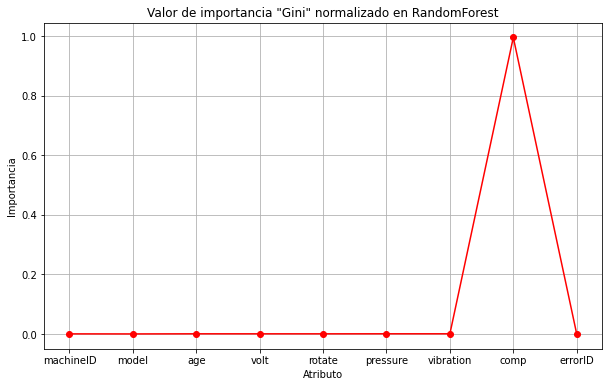

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(dataset_train_x.columns, imp, 'ro-', label='green') #imp. gini
plt.title('Valor de importancia "Gini" normalizado en RandomForest')
plt.xlabel("Atributo")
plt.ylabel("Importancia")
plt.grid()

In [ ]:
#REPRESENTAR ÁRBOL DE DECISIÓN (1º ÁRBOL DEL BOSQUE)
# Obtener árbol 1 del bosque
tree = model_RandomForest.estimators_[1]
# Exportar la imagen a un archivo .dot
export_graphviz(tree, out_file = 'tree.dot', feature_names=dataset_train_x.columns, rounded = True, precision = 1)
# Usar el archivo de puntos para crear un gráfico
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Escribir gráfico en un archivo .png
graph.write_png('tree.png')

In [ ]:
#Leer imagen
img = mpimg.imread('tree.png')

In [ ]:
#Representar
plt.figure(figsize=(80,80))
plt.imshow(img)

Output hidden; open in https://colab.research.google.com to view.